In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_bool_dtype, is_numeric_dtype, is_object_dtype, is_categorical_dtype, is_integer_dtype, is_float_dtype
# from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
# from dtreeviz.trees import *
from sklearn.tree import export_graphviz
import scipy
from scipy.cluster import hierarchy as hc
from sklearn.inspection import plot_partial_dependence
import yaml
import os
import re
import math
import random
import pickle
import time
from tqdm import tqdm
from collections import defaultdict
from sklearn import base
from sklearn.model_selection import KFold
from pathlib import Path

## Look at Data

In [2]:
path = Path('data')
train_path = path/'inc1'
test_path = path/'inc1/test'
img_path = train_path/'imgs'
model_path = train_path/'models'
img_path.mkdir(exist_ok=True)
model_path.mkdir(exist_ok=True)

In [3]:
train_df = pd.read_feather(train_path/'train.feat')
valid_df = pd.read_feather(train_path/'valid.feat')
print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}")

train_df: (8551728, 104), valid_df: (2119548, 104)


In [4]:
((train_df.GFlops <= 0).sum() / len(train_df) * 100), ((valid_df.GFlops <= 0).sum() / len(valid_df) * 100)

(6.769017910766105, 3.973299967728969)

In [5]:
train_df = train_df[train_df['GFlops'] > 0].reset_index(drop=True)
valid_df = valid_df[valid_df['GFlops'] > 0].reset_index(drop=True)
print(f"train_df: {train_df.shape}, valid_df: {valid_df.shape}")

train_df: (7972860, 104), valid_df: (2035332, 104)


In [6]:
def classify_df(df):
    for n, c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def apply_cats(df, src_df):
    for n, c in df.items():
        if n in src_df.columns and src_df[n].dtype.name == 'category':
            df[n] = df[n].astype('category').cat.as_ordered()
            df[n].cat.set_categories(src_df[n].cat.categories, ordered=True, inplace=True)
    
def tolist(x):
    if isinstance(x, str): return [x]
    elif isinstance(x, tuple): return list(x)
    return x

def tostr(x):
    if isinstance(x, [list, tuple]): return '_'.join(x)
    return x

def kfold_target_encoding(train_df, recipies, n_fold=5):
    tme_cols = []
    train_new = train_df.copy()
    for i, (gby_col, target_col, op) in enumerate(recipies):
        kf = KFold(n_splits=n_fold, shuffle=True, random_state=21)
        for tr_ind, val_ind in kf.split(train_df):
            trn_df, val_df = train_df.iloc[tr_ind], train_df.iloc[val_ind]
            agg = trn_df.groupby(gby_col)[target_col].agg(op)
            col_names = ['_'.join([gby_col, c, 'target']) for c in agg.columns]
            agg.columns = col_names
            for c in col_names:
                train_new.loc[val_ind, c] = val_df[gby_col].map(agg[c])
            tme_cols.extend(col_names)
        train_new.fillna(train_df[target_col].median(), inplace=True)
    return train_new, np.unique(tme_cols)

def gen_tme_feat(trn_df):
    agg_op = ['mean', 'median']
    dep_var = 'GFlops'
    recipies = [
        ('SolutionName', dep_var, agg_op),
    ]
    return kfold_target_encoding(trn_df, recipies)

# apply target mean encoding by train dataframe
def apply_tme_feat(df, train_df, tme_cols):
    for c in tme_cols:
        gby_cols = c.split('_')[:-2]
        gp = train_df[gby_cols + [c]].groupby(gby_cols).mean().reset_index()
        df = df.merge(gp, on=gby_cols, how='left')
        df.fillna(df[c].median(), inplace=True)
    return df

def train_cats(df):
    for n, c in df.items():
        if is_object_dtype(c):
            df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, train_df):
    for n,c in df.items():
        if (n in train_df.columns) and (train_df[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(train_df[n].cat.categories, ordered=True, inplace=True)

def categorify(df):
    for n, c in df.items():
        if is_bool_dtype(c):
            df[n] = c.astype('int8')
        elif not is_numeric_dtype(c):
            df[n] = pd.Categorical(c).codes + 1

def preproc_df(df):
#     nn_idxs = np.where(df['ProblemType'].apply(lambda x: 'Ailk_Bljk' in x))
#     tn_idxs = np.where(df['ProblemType'].apply(lambda x: 'Alik_Bljk' in x))
#     nt_idxs = np.where(df['ProblemType'].apply(lambda x: 'Ailk_Bjlk' in x))
#     df.loc[nn_idxs]['PadA'] = df['LDA'] - df['SizeI']
#     df.loc[nn_idxs]['PadB'] = df['LDB'] - df['SizeL']
    df['PadC'] = df['LDC'] - df['SizeI']
#     df.loc[tn_idxs]['PadA'] = df['LDA'] - df['SizeL']
#     df.loc[nt_idxs]['PadB'] = df['LDB'] - df['SizeJ']
    df['AspectRatioA'] = (df['SizeL'] / df['SizeI']).astype('float32')
    df['AspectRatioB'] = (df['SizeJ'] / df['SizeL']).astype('float32')
    df['AspectRatioC'] = (df['SizeJ'] / df['SizeI']).astype('float32')
    df['AreaA'] = (df['SizeI'] * df['SizeL']).astype('int64')
    df['AreaB'] = (df['SizeJ'] * df['SizeL']).astype('int64')
    df['AreaC'] = (df['SizeI'] * df['SizeJ']).astype('int64')
    df['AoverB'] = (df['AreaA'] / df['AreaB']).astype('float32')
#     df['TotalFlops'] = df['TotalFlops'] / 1e9
    dup_cols = ['LDD', 'MacroTileA', 'MacroTileB','SubGroupA', 'SubGroupB',
                'ThreadTileA', 'ThreadTileB', 'MatrixInstBM', 'MatrixInstN']
    df.drop(dup_cols, axis=1, inplace=True)

In [7]:
preproc_df(train_df)
preproc_df(valid_df)
train_cats(train_df)
apply_cats(valid_df, train_df)
categorify(train_df)
categorify(valid_df)

In [8]:
train_df.columns

Index(['SizeI', 'SizeJ', 'SizeK', 'SizeL', 'LDC', 'LDA', 'LDB', 'TotalFlops',
       '1LDSBuffer', 'AssertFree0ElementMultiple',
       ...
       'GFlops', 'Ranking', 'PadC', 'AspectRatioA', 'AspectRatioB',
       'AspectRatioC', 'AreaA', 'AreaB', 'AreaC', 'AoverB'],
      dtype='object', length=103)

## Ranking

In [9]:
train_df.drop(['GFlops'], axis=1, inplace=True)
valid_df.drop(['GFlops'], axis=1, inplace=True)
dep_var = 'Ranking'
y, valid_y = np.log1p(train_df[dep_var].values), np.log1p(valid_df[dep_var].values)
xs = train_df.drop(dep_var, axis=1).copy()
valid_xs = valid_df.drop(dep_var, axis=1).copy()
del train_df, valid_df

In [11]:
def rmse(pred,y):
    return round(math.sqrt(((pred-y)**2).mean()), 4)

def m_rmse(m, xs, y):
    return rmse(m.predict(xs), y)

def eval_model(m, trn_xs, trn_y, val_xs, val_y):
    return m_rmse(m, trn_xs, trn_y), m_rmse(m, val_xs, val_y)

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

def cluster_columns(df, figsize=(10,6), font_size=12, fig_path=img_path/'cc.png'):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns.tolist(), orientation='left', leaf_font_size=font_size)
    plt.show()
    plt.savefig(fig_path)
    
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=25, max_samples=500_000, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
                                  min_samples_leaf=min_samples_leaf,
                                  max_samples=max_samples, **kwargs).fit(xs, y)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi, fig=img_path/'fi.png'):
    fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
    plt.savefig(fig)

In [12]:
m = rf(xs, y)
print("First", eval_model(m, xs, y, valid_xs, valid_y))

First (0.039, 0.05)


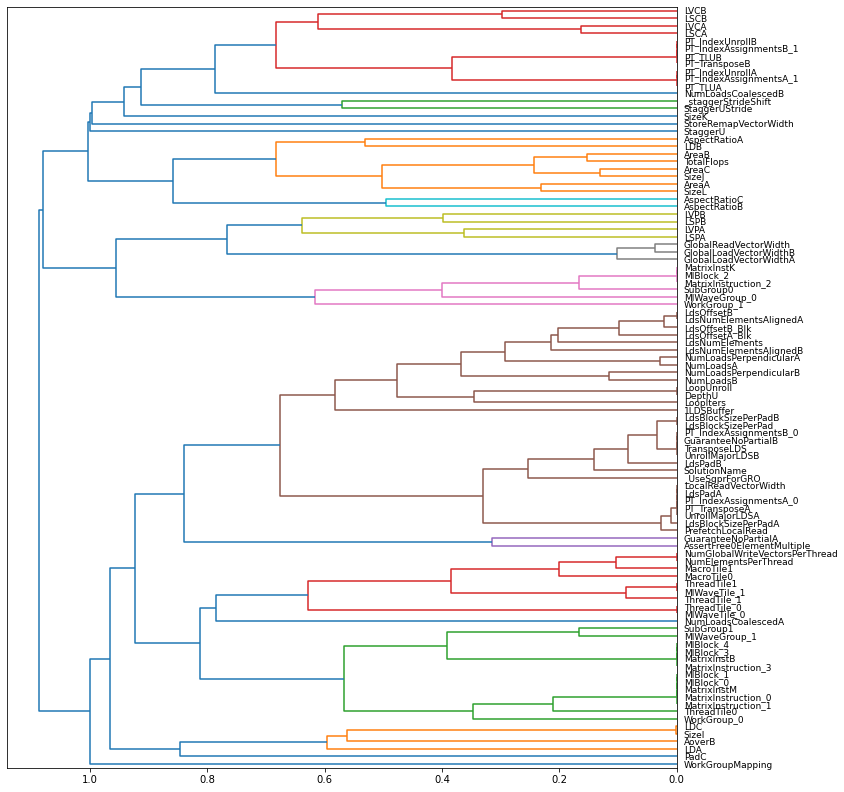

<Figure size 432x288 with 0 Axes>

In [13]:
del m
cluster_columns(valid_xs, figsize=(12, 14), font_size=9);

In [14]:
drop_cols = ['MIBlock_2', 'MatrixInstruction_2',
              'LdsBlockSizePerPadB',
              'NumGlobalWriteVectorsPerThread',
              'PT_IndexAssignmentsB_0', 'TransposeLDS', 'UnrollMajorLDSB',
              'PT_TransposeA', 'LdsPadA', 'PT_IndexAssignmentsA_0', 'UnrollMajorLDSA',
              'LdsNumElementsAlignedA',
              'DepthU',
              'PT_IndexAssignmentsB_1', 'PT_IndexUnrollB', 'PT_TransposeB',
              'PT_IndexUnrollA', 'PT_IndexAssignmentsA_1',
              'NumGlobalWriteVectorsPerThread',
              'MIWaveTile_0',
              'MIWaveTile_1',
              'MatrixInstruction_3', 'MIBlock_3', 'MIBlock_4',
              'MatrixInstruction_0', 'MatrixInstruction_1', 'MIBlock_0', 'MIBlock_1']
xs.drop(drop_cols, axis=1, inplace=True)
valid_xs.drop(drop_cols, axis=1, inplace=True)

In [16]:
m = rf(xs, y)
print("Drop Dup-cols", eval_model(m, xs, y, valid_xs, valid_y))

Drop Dup-cols (0.0391, 0.0498)


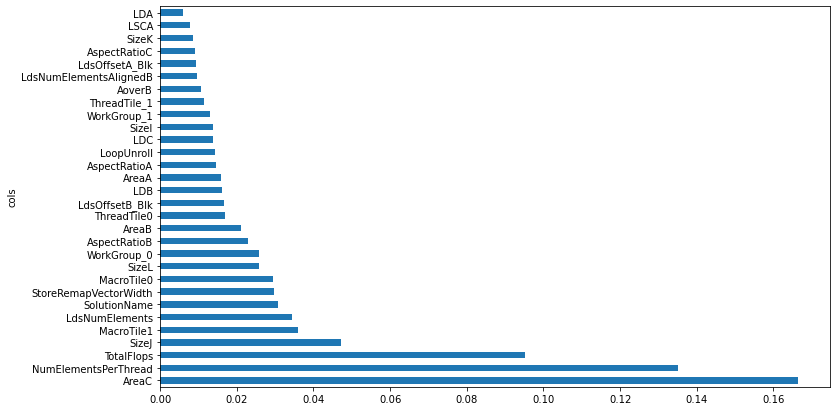

In [17]:
fi = rf_feat_importance(m, xs)
plot_fi(fi[:30])

In [18]:
to_keep = fi[fi.imp > 0.001].cols
xs_keep, valid_xs_keep = xs[to_keep], valid_xs[to_keep]
del m
m = rf(xs_keep, y)
print("imp > 0.001", eval_model(m, xs_keep, y, valid_xs_keep, valid_y))

imp > 0.001 (0.0393, 0.05)


In [20]:
len(xs_keep.columns), len(xs.columns), xs_keep.columns

(63,
 74,
 Index(['AreaC', 'NumElementsPerThread', 'TotalFlops', 'SizeJ', 'MacroTile1',
        'LdsNumElements', 'SolutionName', 'StoreRemapVectorWidth', 'MacroTile0',
        'SizeL', 'WorkGroup_0', 'AspectRatioB', 'AreaB', 'ThreadTile0',
        'LdsOffsetB_Blk', 'LDB', 'AreaA', 'AspectRatioA', 'LoopUnroll', 'LDC',
        'SizeI', 'WorkGroup_1', 'ThreadTile_1', 'AoverB',
        'LdsNumElementsAlignedB', 'LdsOffsetA_Blk', 'AspectRatioC', 'SizeK',
        'LSCA', 'LDA', 'AssertFree0ElementMultiple', 'ThreadTile1',
        'LdsOffsetB', 'LoopIters', 'LVPA', 'LSCB', 'SubGroup0', 'MatrixInstK',
        'SubGroup1', 'ThreadTile_0', 'GuaranteeNoPartialA', 'LVPB',
        'MIWaveGroup_0', 'MIWaveGroup_1', 'MatrixInstM', '_UseSgprForGRO',
        'NumLoadsB', 'LSPA', 'GlobalLoadVectorWidthB', 'WorkGroupMapping',
        'NumLoadsPerpendicularB', 'PT_TLUB', 'GlobalLoadVectorWidthA',
        'GlobalReadVectorWidth', 'LdsBlockSizePerPad', 'LdsPadB',
        'NumLoadsCoalescedB', 'LSPB', 'LVCA

## is_valid

In [21]:
df = pd.concat([xs_keep, valid_xs_keep])
is_valid = np.array([0] * len(xs_keep) + [1] * len(valid_xs_keep))
m = rf(df, is_valid)
fi = rf_feat_importance(m, df)
fi[:20]

,cols,imp
2,TotalFlops,0.132739
11,AspectRatioB,0.102350
12,AreaB,0.079050
0,AreaC,0.075440
26,AspectRatioC,0.067876
23,AoverB,0.067275
17,AspectRatioA,0.063705
16,AreaA,0.059344
3,SizeJ,0.051392
9,SizeL,0.048695


In [23]:
m = rf(xs_keep, y, max_samples=500_000)
print('original', eval_model(m, xs_keep, y, valid_xs_keep, valid_y))
for c in fi[fi.imp > 0.01].cols.values:
    if c in xs_keep:
        m = rf(xs_keep.drop(c, axis=1), y, max_samples=500_000)
        print(c, eval_model(m, xs_keep.drop(c, axis=1), y, valid_xs_keep.drop(c, axis=1), valid_y))
        del m

original (0.0394, 0.0503)
TotalFlops (0.0398, 0.051)
AspectRatioB (0.0396, 0.0502)
AreaB (0.0395, 0.0501)
AreaC (0.0407, 0.0537)
AspectRatioC (0.0396, 0.0501)
AoverB (0.0395, 0.05)
AspectRatioA (0.0395, 0.0501)
AreaA (0.0395, 0.0501)
SizeJ (0.0394, 0.0501)
SizeL (0.0395, 0.0501)
SolutionName (0.0397, 0.0504)
LDB (0.0396, 0.0503)
LDA (0.0395, 0.0503)
SizeK (0.0396, 0.0505)
PrefetchLocalRead (0.0395, 0.0502)
LDC (0.0395, 0.0503)
SizeI (0.0394, 0.0503)
LdsPadB (0.0393, 0.0498)


In [32]:
# drop_cols = ['AspectRatioB', 'AreaB', 'AspectRatioC', 'AoverB', 'AspectRatioA', 'AreaA', 
#              'LDA', 'LDB', 'LDC', 'PrefetchLocalRead', 'LdsPadB'] #'SizeI', 'SizeJ', 'SizeL', 
drop_cols = ['AspectRatioB', 'LdsPadB', 'AoverB']
drop_cols = [n for n in drop_cols if n in xs_keep]
del m
m = rf(xs_keep.drop(drop_cols, axis=1), y, max_samples=500_000)
eval_model(m, xs_keep.drop(drop_cols, axis=1), y, valid_xs_keep.drop(drop_cols, axis=1), valid_y)

(0.0397, 0.05)

In [36]:
xs_final, valid_xs_final = xs_keep.drop(drop_cols, axis=1), valid_xs_keep.drop(drop_cols, axis=1)

KeyError: "['AspectRatioB' 'LdsPadB' 'AoverB'] not found in axis"

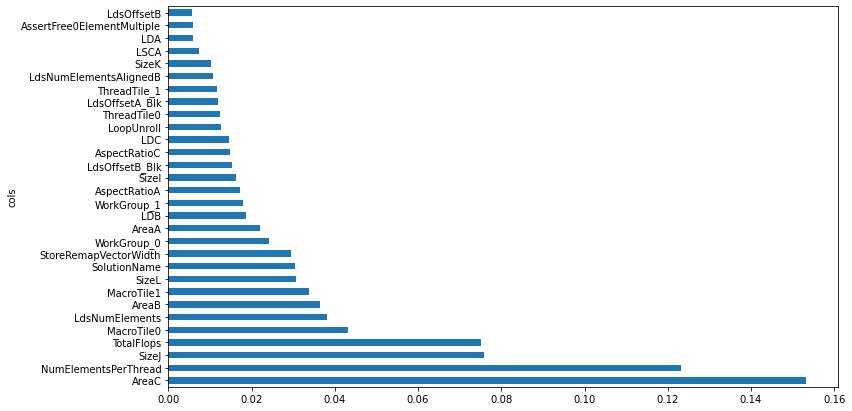

In [39]:
fi = rf_feat_importance(m, xs_final)
plot_fi(fi[:30])

In [40]:
fi

,cols,imp
0,AreaC,0.153216
1,NumElementsPerThread,0.123127
3,SizeJ,0.075748
2,TotalFlops,0.075060
8,MacroTile0,0.043152
5,LdsNumElements,0.038090
11,AreaB,0.036515
4,MacroTile1,0.033849
9,SizeL,0.030658
6,SolutionName,0.030344


In [41]:
len(xs_final.columns), xs_final.columns

(60,
 Index(['AreaC', 'NumElementsPerThread', 'TotalFlops', 'SizeJ', 'MacroTile1',
        'LdsNumElements', 'SolutionName', 'StoreRemapVectorWidth', 'MacroTile0',
        'SizeL', 'WorkGroup_0', 'AreaB', 'ThreadTile0', 'LdsOffsetB_Blk', 'LDB',
        'AreaA', 'AspectRatioA', 'LoopUnroll', 'LDC', 'SizeI', 'WorkGroup_1',
        'ThreadTile_1', 'LdsNumElementsAlignedB', 'LdsOffsetA_Blk',
        'AspectRatioC', 'SizeK', 'LSCA', 'LDA', 'AssertFree0ElementMultiple',
        'ThreadTile1', 'LdsOffsetB', 'LoopIters', 'LVPA', 'LSCB', 'SubGroup0',
        'MatrixInstK', 'SubGroup1', 'ThreadTile_0', 'GuaranteeNoPartialA',
        'LVPB', 'MIWaveGroup_0', 'MIWaveGroup_1', 'MatrixInstM',
        '_UseSgprForGRO', 'NumLoadsB', 'LSPA', 'GlobalLoadVectorWidthB',
        'WorkGroupMapping', 'NumLoadsPerpendicularB', 'PT_TLUB',
        'GlobalLoadVectorWidthA', 'GlobalReadVectorWidth', 'LdsBlockSizePerPad',
        'NumLoadsCoalescedB', 'LSPB', 'LVCA', 'GuaranteeNoPartialB', 'LVCB',
        'Prefetc

In [72]:
pickle.dump(xs_final.columns.values, (model_path/'final_columns.pkl').open('wb'))
# (model_path/'xs_final.pkl').save(xs_final)
# (model_path/'valid_xs_final.pkl').save(valid_xs_final)
# (model_path/'y.pkl').save(y)
# (model_path/'valid_y.pkl').save(valid_y)

## Final

In [61]:
final_cols = pickle.load((model_path/'final_columns.pkl').open('rb'))

train_df = pd.read_feather(train_path/'train.feat')
valid_df = pd.read_feather(train_path/'valid.feat')
train_df = train_df[train_df['GFlops'] > 0].reset_index(drop=True)
valid_df = valid_df[valid_df['GFlops'] > 0].reset_index(drop=True)

preproc_df(train_df)
preproc_df(valid_df)
train_cats(train_df)
apply_cats(valid_df, train_df)
categorify(train_df)
categorify(valid_df)

train_df.drop(['GFlops'], axis=1, inplace=True)
valid_df.drop(['GFlops'], axis=1, inplace=True)
dep_var = 'Ranking'
y, valid_y = np.log1p(train_df[dep_var].values), np.log1p(valid_df[dep_var].values)
xs = train_df.drop(dep_var, axis=1)
valid_xs = valid_df.drop(dep_var, axis=1)
xs_final, valid_xs_final = xs[final_cols].copy(), valid_xs[final_cols].copy()
del xs, valid_xs

In [11]:
def final_rf(xs, y, n_estimators=80, max_features=0.5, min_samples_leaf=10, max_samples=2_000_000, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
                                  min_samples_leaf=min_samples_leaf, max_samples=max_samples, **kwargs).fit(xs, y)

In [16]:
def param_bench(model, params, trn_xs, trn_y, val_xs, val_y):
    res = []
    for f in params['max_features']:
        for s in params['min_samples_leaf']:
            m = model(trn_xs, trn_y, max_features=f, min_samples_leaf=s)
            res.append((f'max_features={f}-min_samples_leaf={s}',
                        m_rmse(m, trn_xs, trn_y), m_rmse(m, val_xs, val_y)))
            del m
    res_sorted = sorted(res, key=lambda x: x[2])
    return res_sorted

In [17]:
params = {
    'max_features': [0.5],
    'min_samples_leaf': [5, 10, 20],
}

res = param_bench(final_rf, params, xs_final, y, valid_xs_final, valid_y)
for o in res:
    print(f"{o[0]}: train = {o[1]:.4f}, valid = {o[2]:.4f}")

max_features=0.5-min_samples_leaf=5: train = 0.0196, valid = 0.0442
max_features=0.5-min_samples_leaf=10: train = 0.0225, valid = 0.0447
max_features=0.5-min_samples_leaf=20: train = 0.0264, valid = 0.0453


In [58]:
def final_rf(xs, y, n_estimators=120, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
                                  min_samples_leaf=min_samples_leaf, max_samples=2_000_000, **kwargs).fit(xs, y)

In [59]:
final_cols = ['AreaC', 'NumElementsPerThread',
        'TotalFlops', 'LdsNumElements', 'StoreRemapVectorWidth', 'SizeL',
        'SolutionName', 'MacroTile1', 'WorkGroup_1', 'WorkGroup_0',
        'MacroTile0', 'LDB', 'AspectRatioA', 'LdsOffsetB_Blk', 'LdsOffsetA_Blk',
        'DepthU', 'LdsNumElementsAlignedB', 'SizeK',
        'AspectRatioC', 'LSCA', 'LoopIters', 'AssertFree0ElementMultiple',
        'ThreadTile0', 'LDA', 'LVPA', 'LSCB',
        'ThreadTile_1', 'LdsOffsetB', 'MatrixInstK',
        'LVPB', 'MIWaveGroup_0', 'GuaranteeNoPartialA', 'SubGroup0',
        'MatrixInstruction_1', 'ThreadTile1', 
        'GlobalLoadVectorWidthB', 'SubGroup1', 'MIWaveGroup_1',
        '_UseSgprForGRO', 'NumLoadsPerpendicularB', 'NumLoadsB',
        'GlobalLoadVectorWidthA', 'GlobalReadVectorWidth', 'ThreadTile_0',
        'LSPB', 'LSPA', 'LVCA', 'LVCB',
        'WorkGroupMapping']

In [62]:
model = final_rf(xs_final, y)
print("Final", eval_model(model, xs_final, y, valid_xs_final, valid_y))

Final (0.0196, 0.0439)


In [63]:
del xs_final, y, valid_xs_final, valid_y

In [ ]:
(model_path/'final_rf_model.pkl').save(model)

## Testing

In [64]:
def mae(p, t): return np.mean(abs(p - t))


def testing(test_csv, n_pct=0.1, topN=3):
    for f in test_csv:
        num_solution = re.findall(ns_pat, f.stem)[0]
        assert num_solution.isdecimal()
        num_solution = eval(num_solution)

        df = pd.read_csv(f, low_memory=False)
        gflops = df['GFlops'].values
        gflops = gflops.reshape(-1, num_solution)
        n = gflops.shape[0]
        topN_target = np.argsort(-gflops)[:, :topN]

        preproc_df(df)
        train_cats(df)
        categorify(df)
        test_xs = df[final_cols]
        preds = model.predict(test_xs)
        preds = np.expm1(preds)
        preds = preds.reshape(gflops.shape)
        num_preds = int(preds.shape[1] * n_pct)
        topN_preds = np.argsort(preds)[:, :num_preds]

        top1_acc, acc = [], []
        for p, t in zip(topN_preds, topN_target):
            if t[0] in p:
                top1_acc.append(True)
                acc.append(True)
            else:
                for o in t[1:]:
                    if o in p:
                        acc.append(True)
                        break

        gflops_preds, gflops_target = [], []
        for i, (p, t) in enumerate(zip(topN_preds, topN_target[:, 0].reshape(-1))):
            max_gflops = 0
            for j in p:
                if gflops[i, j] > max_gflops:
                    max_gflops = gflops[i, j]
            gflops_preds.append(max_gflops)
            gflops_target.append(gflops[i, t])
        gflops_preds, gflops_target = np.array(gflops_preds), np.array(gflops_target)

        print(f"{f.stem}: {n_pct*100}%/{num_preds} solutions, top1 accuracy: {np.sum(top1_acc)/n*100:.2f}%, top{topN} accuracy: {np.sum(acc)/n*100:.2f}%")
        print(f"\t\terrors: {abs(gflops_preds - gflops_target).sum():.2f} GFlops, mean-absolute-errors: {mae(gflops_preds, gflops_target):.2f} GFlops")
        
        fig, axes = plt.subplots(3, 3, figsize=(10, 8))
        x_axis = np.arange(n)
        j = n // 9
        for i, ax in enumerate(axes.flatten()):
            ax.plot(x_axis[i*j:i*j+j], gflops_preds[i*j:i*j+j], label='preds')
            ax.plot(x_axis[i*j:i*j+j], gflops_target[i*j:i*j+j], label='target')
        plt.subplots_adjust(right=1.5)
        plt.legend()
        plt.show()

In [65]:
test_csv = list(test_path.glob('valid_*.csv'))
ns_pat = re.compile(r'_.._N(.*)')

valid_NT_N11052: 2.0%/221 solutions, top1 accuracy: 87.50%, top3 accuracy: 91.25%
		errors: 8452.00 GFlops, mean-absolute-errors: 105.65 GFlops


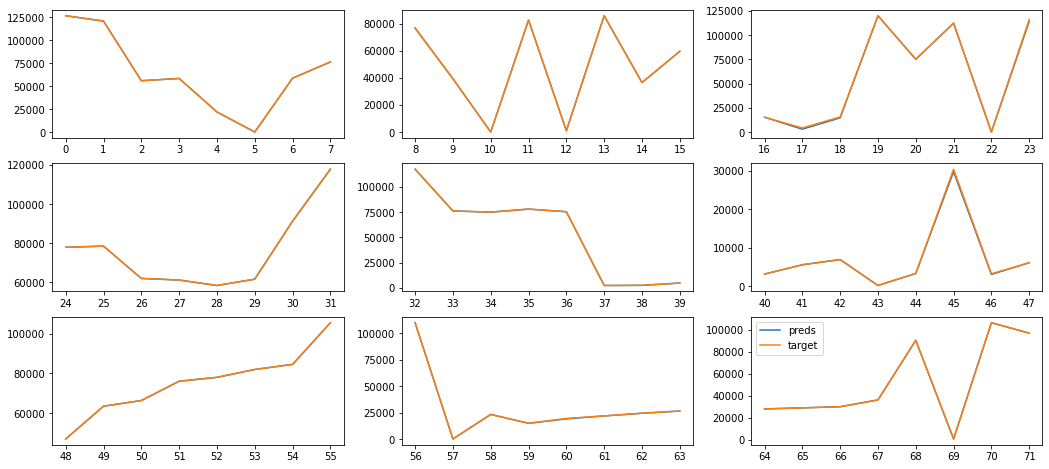

valid_NN_N6372: 2.0%/127 solutions, top1 accuracy: 63.64%, top3 accuracy: 71.43%
		errors: 104125.00 GFlops, mean-absolute-errors: 1352.27 GFlops


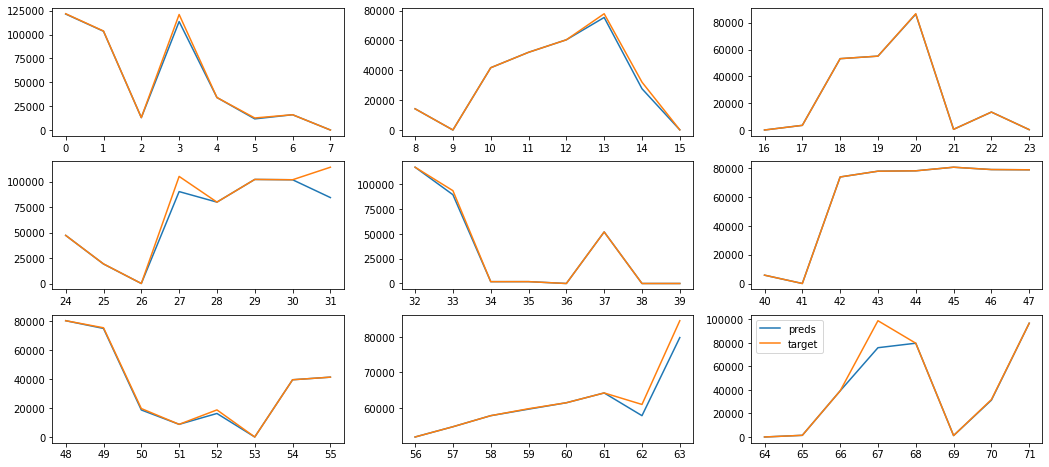

valid_TN_N9672: 2.0%/193 solutions, top1 accuracy: 40.26%, top3 accuracy: 49.35%
		errors: 128662.00 GFlops, mean-absolute-errors: 1670.94 GFlops


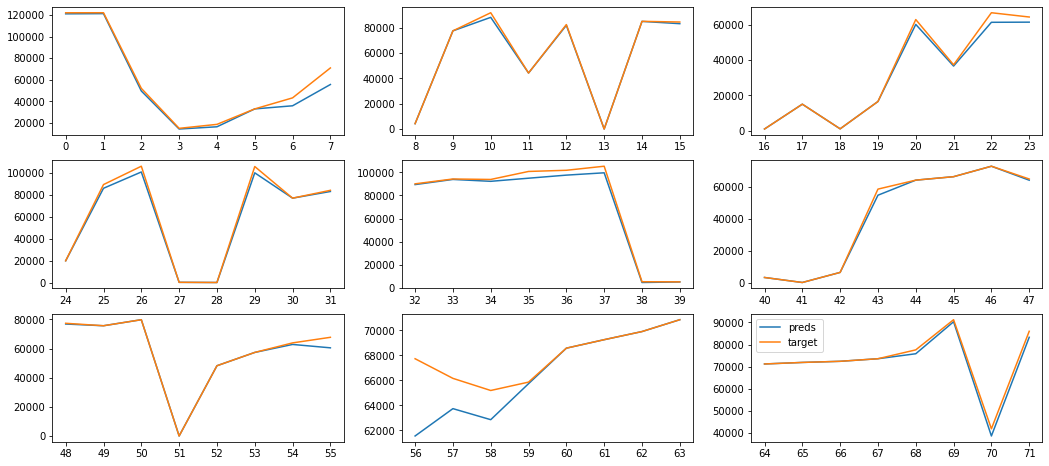

In [66]:
testing(test_csv, n_pct=0.02)

valid_NT_N11052: 5.0%/552 solutions, top1 accuracy: 96.25%, top3 accuracy: 96.25%
		errors: 3120.00 GFlops, mean-absolute-errors: 39.00 GFlops


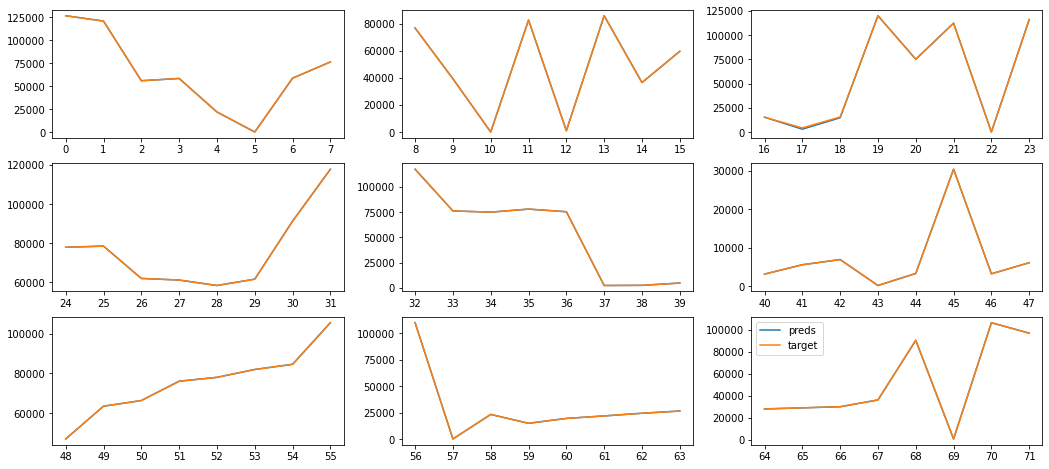

valid_NN_N6372: 5.0%/318 solutions, top1 accuracy: 74.03%, top3 accuracy: 83.12%
		errors: 68746.00 GFlops, mean-absolute-errors: 892.81 GFlops


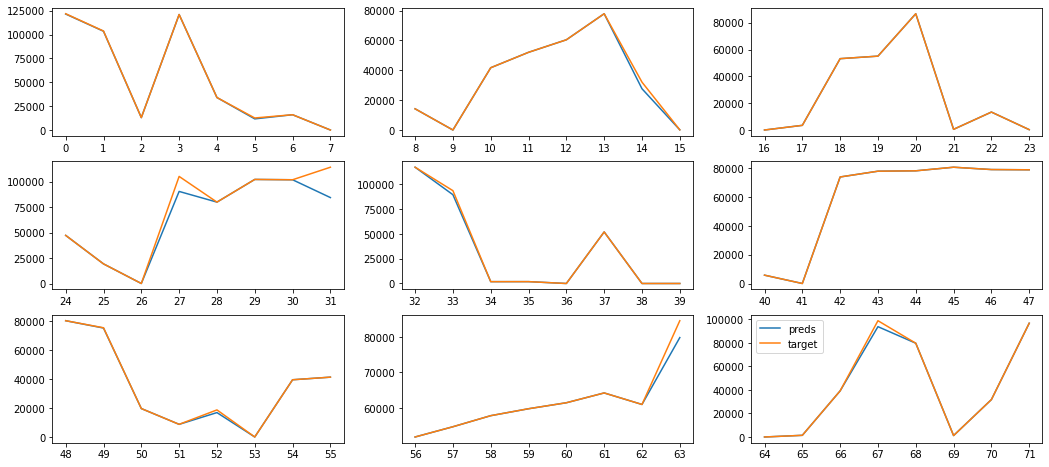

valid_TN_N9672: 5.0%/483 solutions, top1 accuracy: 58.44%, top3 accuracy: 66.23%
		errors: 72403.00 GFlops, mean-absolute-errors: 940.30 GFlops


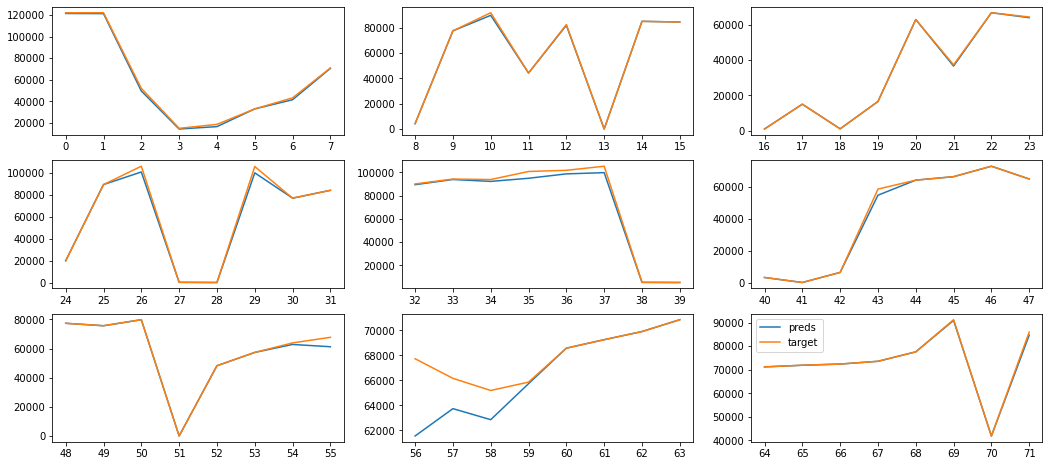

In [67]:
testing(test_csv, n_pct=0.05)

valid_NT_N11052: 10.0%/1105 solutions, top1 accuracy: 97.50%, top3 accuracy: 97.50%
		errors: 1760.00 GFlops, mean-absolute-errors: 22.00 GFlops


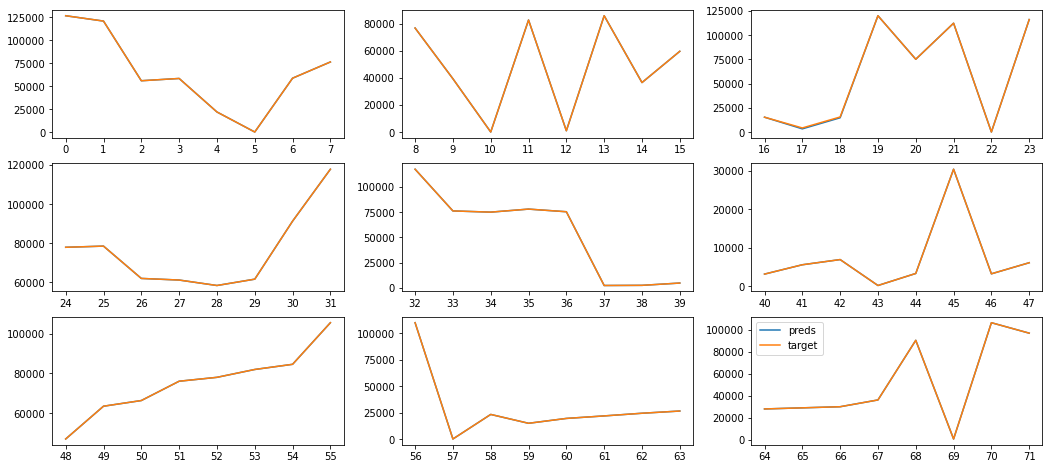

valid_NN_N6372: 10.0%/637 solutions, top1 accuracy: 83.12%, top3 accuracy: 92.21%
		errors: 21162.00 GFlops, mean-absolute-errors: 274.83 GFlops


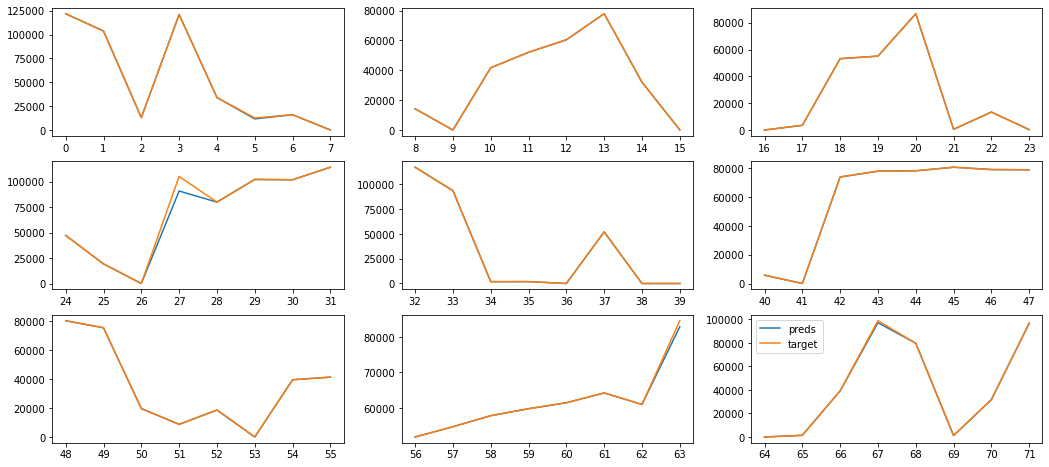

valid_TN_N9672: 10.0%/967 solutions, top1 accuracy: 81.82%, top3 accuracy: 87.01%
		errors: 17723.00 GFlops, mean-absolute-errors: 230.17 GFlops


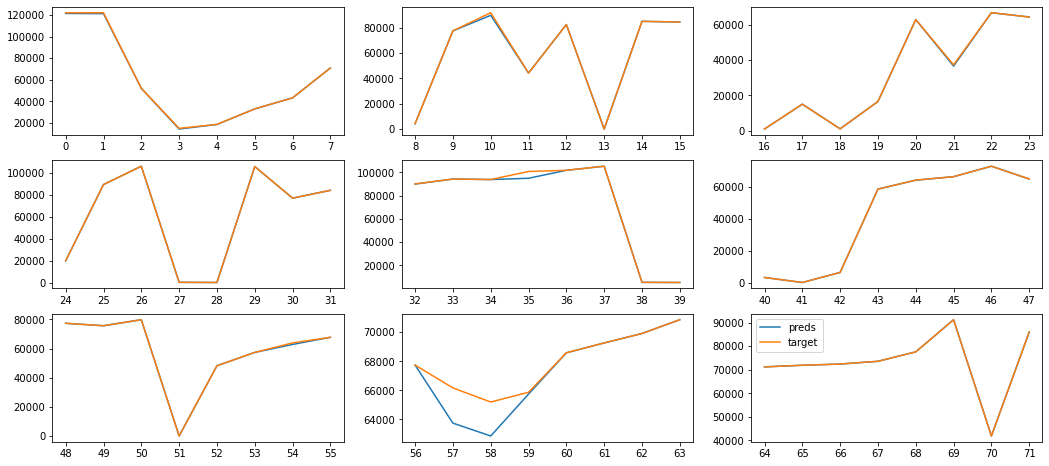

In [68]:
testing(test_csv, n_pct=0.1)

valid_NT_N11052: 15.0%/1657 solutions, top1 accuracy: 98.75%, top3 accuracy: 98.75%
		errors: 814.00 GFlops, mean-absolute-errors: 10.18 GFlops


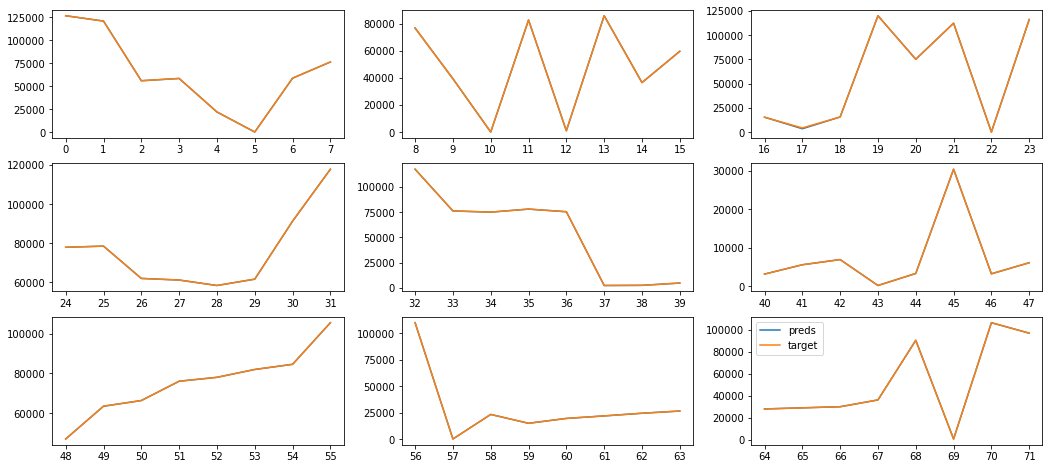

valid_NN_N6372: 15.0%/955 solutions, top1 accuracy: 88.31%, top3 accuracy: 94.81%
		errors: 4238.00 GFlops, mean-absolute-errors: 55.04 GFlops


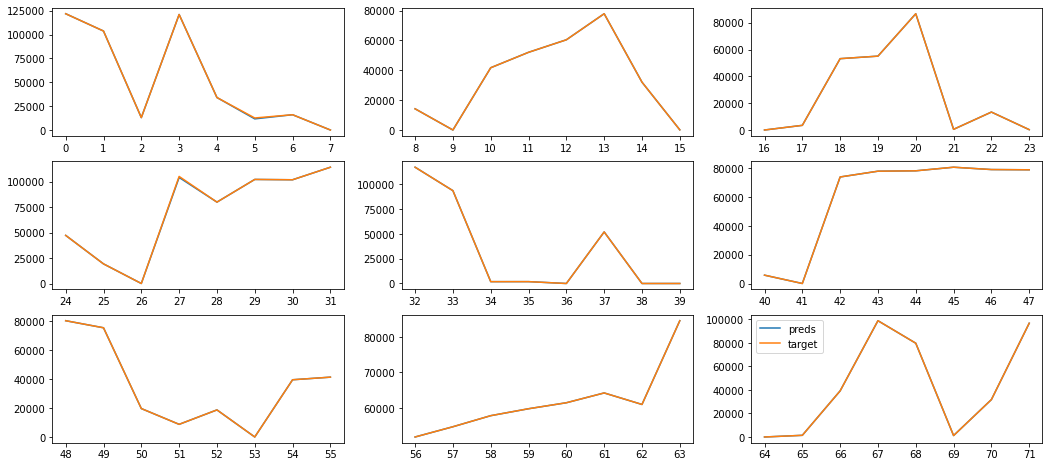

valid_TN_N9672: 15.0%/1450 solutions, top1 accuracy: 97.40%, top3 accuracy: 98.70%
		errors: 981.00 GFlops, mean-absolute-errors: 12.74 GFlops


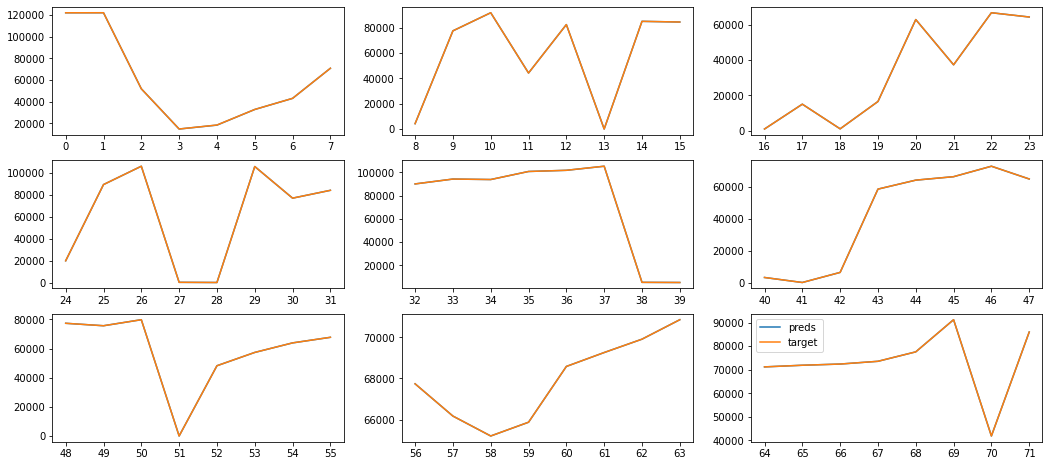

In [69]:
testing(test_csv, n_pct=0.15)

valid_NT_N11052: 25.0%/2763 solutions, top1 accuracy: 98.75%, top3 accuracy: 98.75%
		errors: 434.00 GFlops, mean-absolute-errors: 5.42 GFlops


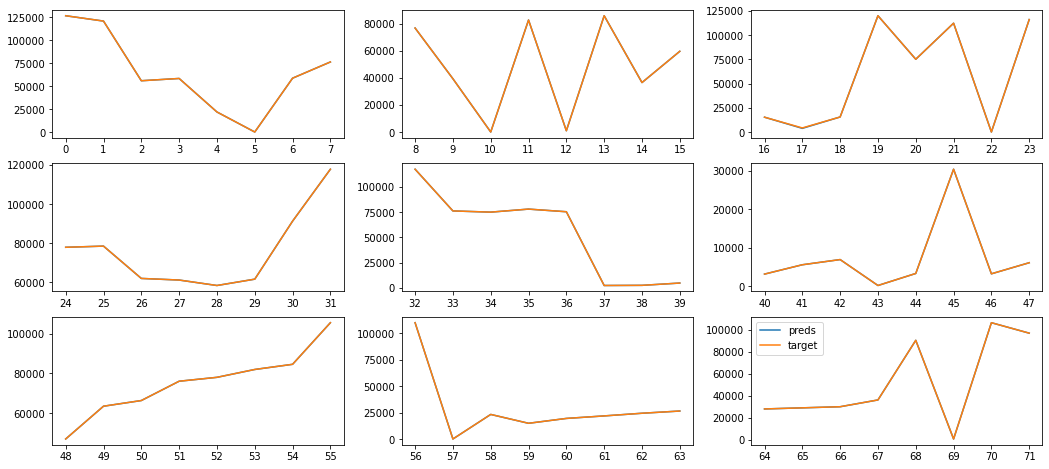

valid_NN_N6372: 25.0%/1593 solutions, top1 accuracy: 97.40%, top3 accuracy: 100.00%
		errors: 1.00 GFlops, mean-absolute-errors: 0.01 GFlops


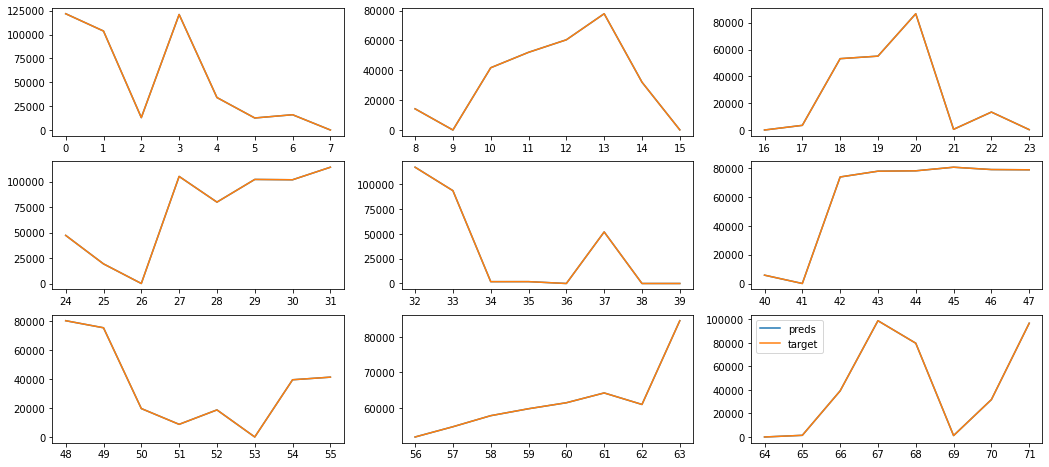

valid_TN_N9672: 25.0%/2418 solutions, top1 accuracy: 98.70%, top3 accuracy: 100.00%
		errors: 111.00 GFlops, mean-absolute-errors: 1.44 GFlops


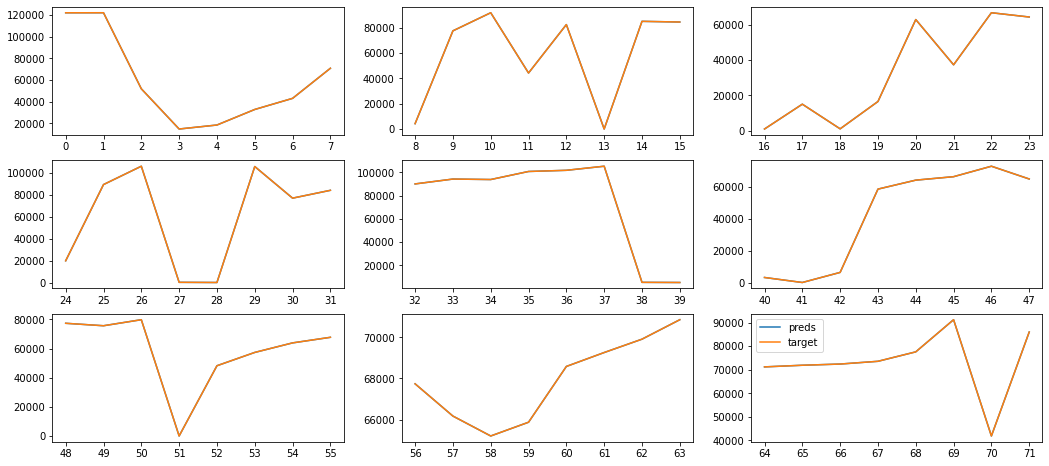

In [70]:
testing(test_csv, n_pct=0.25)

## Partial Depend

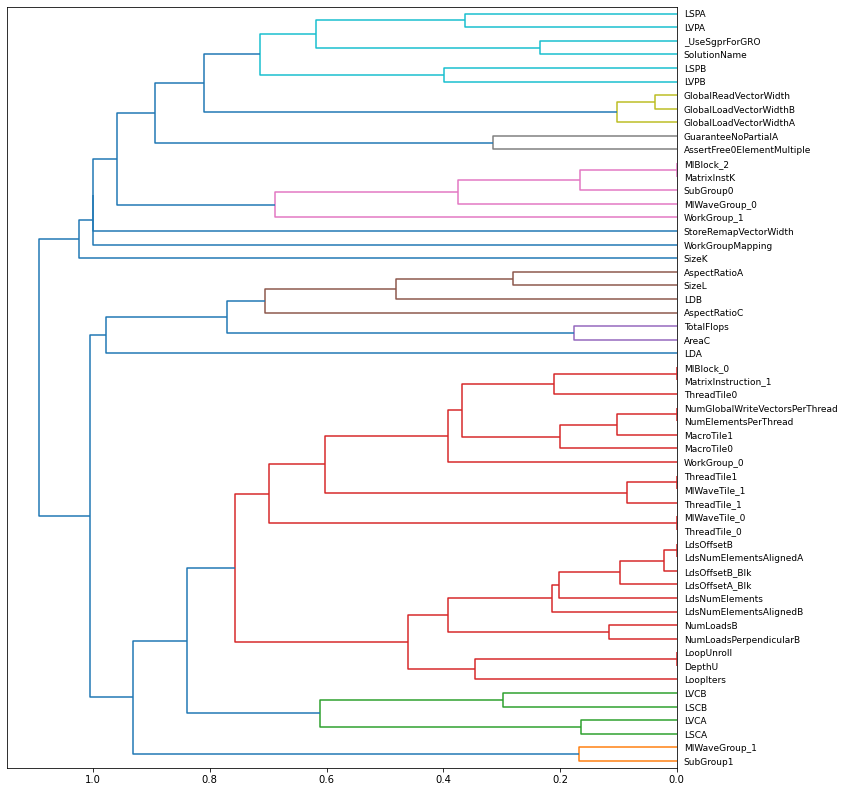

<Figure size 432x288 with 0 Axes>

In [137]:
cluster_columns(valid_xs_final, figsize=(12, 12), font_size=9);

In [138]:
valid_xs_final.columns

Index(['AreaC', 'NumElementsPerThread', 'NumGlobalWriteVectorsPerThread',
       'TotalFlops', 'LdsNumElements', 'StoreRemapVectorWidth', 'SizeL',
       'SolutionName', 'MacroTile1', 'WorkGroup_1', 'WorkGroup_0',
       'MacroTile0', 'LDB', 'AspectRatioA', 'LdsOffsetB_Blk', 'LdsOffsetA_Blk',
       'DepthU', 'LoopUnroll', 'LdsNumElementsAlignedB', 'SizeK',
       'AspectRatioC', 'LSCA', 'LoopIters', 'AssertFree0ElementMultiple',
       'MIWaveTile_1', 'ThreadTile0', 'LDA', 'LVPA', 'LSCB',
       'LdsNumElementsAlignedA', 'ThreadTile_1', 'LdsOffsetB', 'MatrixInstK',
       'LVPB', 'MIWaveGroup_0', 'GuaranteeNoPartialA', 'SubGroup0',
       'MatrixInstruction_1', 'ThreadTile1', 'MIBlock_0',
       'GlobalLoadVectorWidthB', 'SubGroup1', 'MIWaveGroup_1',
       '_UseSgprForGRO', 'NumLoadsPerpendicularB', 'NumLoadsB',
       'GlobalLoadVectorWidthA', 'GlobalReadVectorWidth', 'ThreadTile_0',
       'MIBlock_2', 'LSPB', 'LSPA', 'LVCA', 'LVCB', 'MIWaveTile_0',
       'WorkGroupMapping'],
    

In [140]:
drop_cols = ['MIBlock_2', 'MIBlock_0', 'NumGlobalWriteVectorsPerThread', 'MIWaveTile_0',
              'MIWaveTile_1', 'LdsNumElementsAlignedA', 'LoopUnroll']
drop_cols = [n for n in drop_cols if n in xs_final]
xs_final.drop(drop_cols, axis=1, inplace=True)
valid_xs_final.drop(drop_cols, axis=1, inplace=True)

In [142]:
len(xs_final.columns)

49

In [ ]:
def final_rf(xs, y, n_estimators=120, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_features=max_features,
                                  min_samples_leaf=min_samples_leaf, max_samples=2_000_000, **kwargs).fit(xs, y)

model = final_rf(xs_final, y)
print("Final", eval_model(model, xs_final, y, valid_xs_final, valid_y))